# Comparison


In [1]:
import pandas as pd
import numpy as np
import os
import pickle

pd.set_option("display.max_columns", None)

In [2]:
from scripts.params import get_params
from scripts.aux_functions import get_all_results_matching, subset_of_columns, clean_modelname

params = get_params()

In [3]:
from scripts.epftoolbox_dm_gw import DM, plot_multivariate_DM_test, GW, plot_multivariate_GW_test

In [4]:
dataroute = params["dataroute"]
resultsroute = params["resultsroute"]
dumproute = params["dumproute"]
graphsroute = params["graphsroute"]
dmroute=params["dmroute"]
gwroute=params["gwroute"]

In [5]:
start_test = params["start_test"]
local_suffix = params["local_suffix"]

In [6]:
name = f'finaldf_test_{params["tablename"]}.pickle'
filename = os.path.join(dataroute, name)
with open(filename, "rb") as handle:
    df_test = pickle.load(handle)
    
df_test.index=pd.to_datetime(df_test.index.copy())

In [7]:
all_forecasts = get_all_results_matching(params["resultsroute"], ["best_forecast"])
all_residuals = get_all_results_matching(params["resultsroute"], ["best_residuals"])

{'GARCH_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\GARCH_BR_^BVSP_aic_best_forecasts.pickle', 'GARCH_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\GARCH_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_multiv_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_multiv_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_univ_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_univ_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_univ_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_univ_BR_^BVSP_bic_best_forecasts.pickle', 'HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_with_vol_BR_^BVSP_aic_best_forecasts.pickle', 'HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle': '..\\results\\BR_^BVSP\\HMM_with_vol_BR_^BVSP_bic_best_forecasts.pickle', 'VAR_multiv_BR_^BVSP_aic_best_forecasts.pickle': '.

In [8]:
def open_pickle_route(route:str):
    with open(route, "rb") as file:
        dictionary = pickle.load(file)
    return dictionary

In [9]:
def create_prefix(picklename:str):
    picklename=picklename.replace(f"""{params["tablename"]}_""", "").replace(".pickle", "").replace("_residuals", "").replace("_forecasts", "").replace("best", "")
    return picklename

In [10]:
def concat_dictionary(dictionary:dict, prefix:str):
    colname_list=[]
    df_list=[]
    for key, value in dictionary.items():
        value.index = pd.to_datetime(value.index)
        value = subset_of_columns(value, "log_rets", "USD")
        
        df_list.append(value)
        
        colname = prefix + key
        colname_list.append(colname)
    
    pickledf = pd.concat(df_list, axis=1, join="outer")
    pickledf.columns = colname_list
    
    return pickledf

In [11]:
def aggregate_single_pickle(picklename:str, pickleroute:str):
    prefix = create_prefix(picklename)
    dictionary = open_pickle_route(pickleroute)
    pickledf = concat_dictionary(dictionary, prefix)
    return pickledf

In [12]:
def aggregate_dict(dictionary:dict):
    pickledf_list=[]
    for picklename, pickleroute in dictionary.items():
        pickledf = aggregate_single_pickle(picklename, pickleroute)
        pickledf_list.append(pickledf)
    aggdf = pd.concat(pickledf_list, axis=1, join="outer")
    
    return aggdf

In [13]:
forecasts = aggregate_dict(all_forecasts)
residuals = aggregate_dict(all_residuals)

In [14]:
lower_date=pd.to_datetime(params["start_test"])+pd.Timedelta(days=1)
higher_date=pd.to_datetime(params["end_test"])-pd.Timedelta(days=1)

forecasts_df=forecasts[lower_date:higher_date].copy()
residual_df=residuals[lower_date:higher_date].copy()
df_test = df_test[lower_date:higher_date].copy()

In [15]:
# estadisticos de nans
nans_forecasts=((forecasts_df.isna().sum(axis=0) / len(forecasts_df.index)) * 100).nlargest(10)
assert nans_forecasts.iloc[0]<5, "Forecast NANs above 5%"
nans_forecasts

GARCH_aic_BVSP_FX     0.0
GARCH_aic_^BVSP       0.0
GARCH_aic_VALE3.SA    0.0
GARCH_aic_VALE        0.0
GARCH_aic_PETR3.SA    0.0
GARCH_aic_PBR         0.0
GARCH_aic_EMBR3.SA    0.0
GARCH_aic_ERJ         0.0
GARCH_aic_ABEV3.SA    0.0
GARCH_aic_ABEV        0.0
dtype: float64

In [16]:
# estadisticos de nans
nans_residual=((residual_df.isna().sum(axis=0) / len(residual_df.index)) * 100).nlargest(10)
assert nans_residual.iloc[0]<5, "Forecast NANs above 5%"
nans_residual

GARCH_aic_BVSP_FX     0.0
GARCH_aic_^BVSP       0.0
GARCH_aic_VALE3.SA    0.0
GARCH_aic_VALE        0.0
GARCH_aic_PETR3.SA    0.0
GARCH_aic_PBR         0.0
GARCH_aic_EMBR3.SA    0.0
GARCH_aic_ERJ         0.0
GARCH_aic_ABEV3.SA    0.0
GARCH_aic_ABEV        0.0
dtype: float64

## Separating in different stocks

In [17]:
params["assetlist"]

['BVSP_FX', '^BVSP', 'ABEV3.SA', 'ABEV']

In [18]:
def separate_by_stock(df:pd.DataFrame):
     stock_dict={}

     for stock in params["assetlist"]:
          if params["local_suffix"] in stock:
               stock_dict[stock]= subset_of_columns(residual_df, stock)
          else:
               stock_dict[stock]= subset_of_columns(residual_df, stock, params["local_suffix"])    
     
     return stock_dict      

In [19]:
forecasts_by_stock=separate_by_stock(forecasts_df)
residuals_by_stock=separate_by_stock(residual_df)

In [20]:
for df_clean, name in zip([forecasts_by_stock, residuals_by_stock], ["forecasts", "residuals"]):
    bystockname = name + "_by_stock_" + params["tablename"] + ".pickle"
    with open(os.path.join(resultsroute, bystockname), "wb") as handle:
        pickle.dump(df_clean, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
def delete_in_column_names(df:pd.DataFrame, string:str):
    new_cols=[]
    for col in df.columns:
        col=col.replace(string, "")
        new_cols.append(col)
    df=df.set_axis(labels=new_cols, axis=1)
    return df

BVSP_FX


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


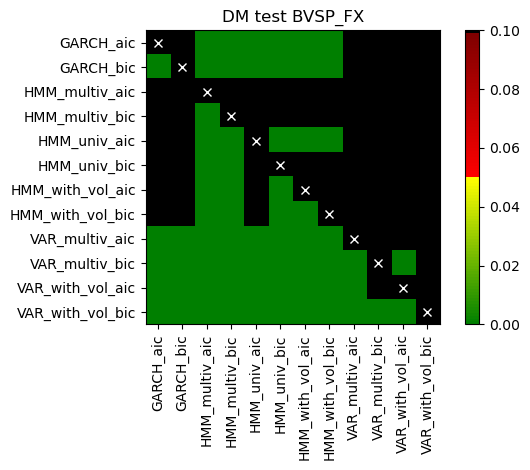

^BVSP


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


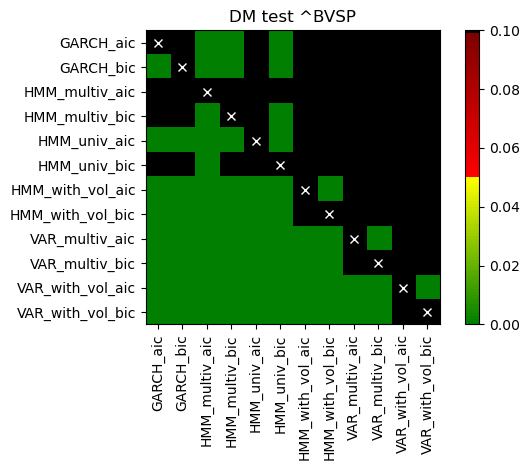

ABEV3.SA


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: invalid value encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)
c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


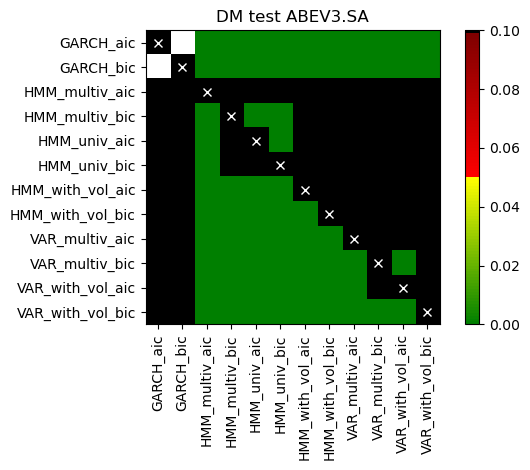

ABEV


c:\Users\alfredo.sampron\Documents\GitHub\regime-switching-hmm\notebooks\scripts\epftoolbox_dm_gw.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  DM_stat = mean_d / np.sqrt((1 / N) * var_d)


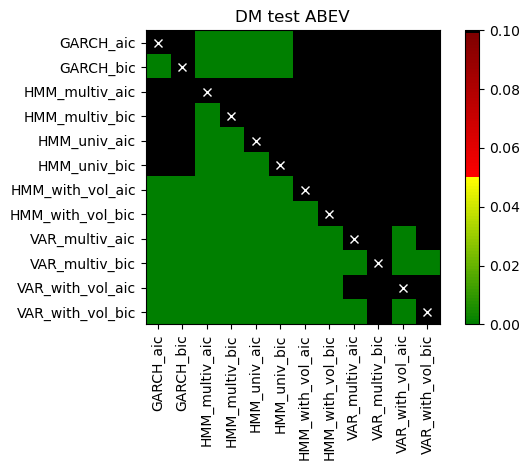

In [22]:
for stock in forecasts_by_stock.keys():
    print(stock)
    real_values=subset_of_columns(df_test, f"{stock}_log_rets")
    forecasts=delete_in_column_names(forecasts_by_stock[stock].fillna(0), f"_{stock}")   

    plot_multivariate_DM_test(real_price=real_values, 
                            forecasts=forecasts.fillna(0), 
                            title=f"DM test {stock}",
                            savefig=True,
                            path=dmroute)

In [23]:
best_models_by_stock={stock:None for stock in residuals_by_stock.keys()}

for stock, dataframe in residuals_by_stock.items():
    dataframe = delete_in_column_names(dataframe, f"_{stock}")
    metrics_df = pd.DataFrame(index=["mse", "meanabs", "medianabs"])

    for column in dataframe.columns:
        single_model=pd.DataFrame(dataframe[column])
        
        metrics_df.loc["mse", column] = (
            (single_model**2).mean().mean()
        )
        metrics_df.loc["meanabs", column] = (
            single_model.abs().mean().mean()
        )
        metrics_df.loc["medianabs", column] = (
            (single_model.abs()).median().median()
        )
    metrics_df = metrics_df * 100
    metrics_df = subset_of_columns(metrics_df, substring="", exclude="USD")
    
    best_dict={}
    for criterion in metrics_df.index:
        best_dict[criterion] = metrics_df.iloc[metrics_df.index==criterion].idxmin(axis="columns").values[0]
        
    best_models_by_stock[stock]= (metrics_df, best_dict)

In [24]:
print(params["tickerlist"][0])
best_models_by_stock[params["tickerlist"][0]][1]

^BVSP


{'mse': 'HMM_with_vol_aic',
 'meanabs': 'HMM_with_vol_aic',
 'medianabs': 'HMM_with_vol_bic'}

In [25]:
best_models_by_stock[params["tickerlist"][0]][0]

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,0.008646,0.008640,0.009413,0.008827,0.009207,0.009392,0.007674,0.007830,0.008761,0.009412,0.009295,0.009278
meanabs,0.755515,0.755869,0.788150,0.759403,0.779227,0.785640,0.698295,0.704215,0.773244,0.789355,0.796535,0.792702
medianabs,0.642359,0.640078,0.665554,0.654303,0.633541,0.662488,0.553267,0.553001,0.693651,0.633645,0.701303,0.712395


In [26]:
best_models_by_stock[params["tickerlist"][0]][0].rank(axis=1)

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,4.0,3.0,12.0,6.0,7.0,10.0,1.0,2.0,5.0,11.0,9.0,8.0
meanabs,3.0,4.0,9.0,5.0,7.0,8.0,1.0,2.0,6.0,10.0,12.0,11.0
medianabs,6.0,5.0,9.0,7.0,3.0,8.0,2.0,1.0,10.0,4.0,11.0,12.0


In [27]:
def create_agg_df(list_to_include:list):
    agg_df=(pd.DataFrame().reindex_like(best_models_by_stock[params["tickerlist"][0]][0]))

    for asset in list_to_include:
        ranks = best_models_by_stock[asset][0].rank(axis=1)
        agg_df = agg_df.add(ranks, fill_value=0)
    agg_df = agg_df/len(list_to_include)
        
    agg_df.rank(axis=1, method="average").astype(int)
    display(agg_df)
    return agg_df

In [28]:
agg_df = create_agg_df(params["tickerlist"]) # all assets

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,8.833333,6.833333,10.666667,6.000000,7.333333,9.333333,2.000000,1.666667,3.000000,9.333333,5.666667,7.333333
meanabs,8.500000,7.833333,7.666667,4.333333,6.666667,8.000000,1.666667,1.333333,4.000000,10.666667,7.333333,10.000000
medianabs,8.166667,8.166667,4.666667,5.666667,4.333333,6.000000,1.333333,2.000000,9.333333,7.666667,10.000000,10.666667


In [29]:
agg_df.to_csv(os.path.join(resultsroute, f"""aggregate_results_df_{params["tablename"]}.csv"""))

In [30]:
criterion="mse"
print(f"Best overall performance by {criterion}")
agg_df.T.nsmallest(3, f"{criterion}").index.to_list()

Best overall performance by mse


['HMM_with_vol_bic', 'HMM_with_vol_aic', 'VAR_multiv_aic']

In [31]:
agg_fx_df = create_agg_df(params["foreignlist"]+[params["synth_index"]])

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,6.5,3.5,10.0,7.0,9.0,10.5,2.5,2.5,4.0,9.5,5.0,8.0
meanabs,6.5,4.5,7.5,5.0,8.5,10.0,3.0,2.0,4.0,9.5,6.5,11.0
medianabs,6.0,7.0,6.0,7.5,4.5,8.0,2.0,5.0,5.5,11.5,5.5,9.5


In [32]:
agg_local_df = create_agg_df(params["foreignlist"]+[params["index"]]) 

,GARCH_aic,GARCH_bic,HMM_multiv_aic,HMM_multiv_bic,HMM_univ_aic,HMM_univ_bic,HMM_with_vol_aic,HMM_with_vol_bic,VAR_multiv_aic,VAR_multiv_bic,VAR_with_vol_aic,VAR_with_vol_bic
mse,7.5,4.5,11.0,5.5,7.0,9.5,1.5,1.5,4.0,11.5,6.5,8.0
meanabs,7.0,6.0,7.5,4.5,7.0,8.5,1.5,1.5,4.5,11.0,8.5,10.5
medianabs,6.5,6.5,5.5,6.5,4.0,6.0,1.5,2.0,10.0,8.0,10.0,11.5


In [33]:
agg_fx_df.to_csv(os.path.join(resultsroute, f"""ONLY_FX_agg_results_{params["tablename"]}.csv"""))
agg_local_df.to_csv(os.path.join(resultsroute, f"""ONLY_LOCAL_agg_results_{params["tablename"]}.csv"""))
